In [2]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime

In [7]:
def row_dot_product_norm_by_numcol(X_zscore, Y_zscore, x_idx, y_idx, 
                                   chunksize=10000, verbose_level=100000):
    """compute (X_zscore[x_idx]*Y_zscore[y_idx]).mean(axis=1)
    correlation values given matched x_idx and y_idx...
    """
    assert len(x_idx) == len(y_idx)
    num_pairs = len(x_idx)
    corrs = []
    for pair_idx in snmcseq_utils.chunks(np.arange(num_pairs), chunksize):
        if pair_idx[0] % verbose_level == 0:
            print(pair_idx[0], time.time()-ti)

        _res = (X_zscore[x_idx[pair_idx]]*Y_zscore[y_idx[pair_idx]]).mean(axis=1)
        corrs.append(_res)
    corrs = np.hstack(corrs) 
    return corrs 

# Todo


work on the plots
- disconnected y axis
- report number and fraction of correlated pairs...

In [8]:
today = datetime.date.today()
print(today)

ka = 2 
k = 2 
name = "corr_analysis_smarter_cells_snmcseq_gene_ka{}_k{}_{}".format(ka, k, today) 

input_knn_xy = '/cndd2/fangming/projects/miniatlas/results/knn_across_mop_2mods_200803_ka{}_k{}_smarter_cells_snmcseq_gene.npz'.format(ka, k)
input_knn_xx = '/cndd2/fangming/projects/miniatlas/results/knn_within_mop_2mods_200803_ka{}_k{}_smarter_cells.npz'.format(ka, k) 
input_knn_cells_xaxis = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/smarter_cells_features.cell'
input_knn_cells_yaxis = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/snmcseq_gene_features.cell'

input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 

input_bundle_dirc = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_july29'
bundle_fnames = (
    'cell_smarter_cells.txt',
    'cell_snmcseq_gene.txt',
    'gene_smarter_cells.txt',
    'enh_snmcseq_gene.tsv',
    
    'mat_smarter_cells.npz',
    'mat_mcg_snmcseq_gene.npz',
    'mat_cg_snmcseq_gene.npz',
    
#     'knn_smarter_cells_snmcseq_gene.npz',
#     'knn_smarter_cells.npz',
)


output_corr = '/cndd2/fangming/projects/scf_enhancers/results/{}_corrs.pkl'.format(name)
output_figure1 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_plot1.pdf'.format(name)
output_figure2 = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_plot1_v2.pdf'.format(name)

SyntaxError: invalid syntax (<ipython-input-8-ab066e90aa1b>, line 4)

# Load data 

In [4]:
# input_bundle
ti = time.time()
with snmcseq_utils.cd(input_bundle_dirc):
    bundle = []
    for fname in bundle_fnames:
        #  save all as pickle file
        with open(fname, "rb") as fh:
            item = pickle.load(fh)
        bundle.append(item)
        print(type(item), item.shape, fname, time.time()-ti)

(common_rna_cells, common_mc_cells, 
 common_genes, common_enhancer_regions,
 X, Y_mcg, Y_cg, 
#  knn_xy, knn_xx,
) = bundle

print(time.time()-ti)

<class 'numpy.ndarray'> (6244,) cell_smarter_cells.txt 0.0028319358825683594
<class 'numpy.ndarray'> (9364,) cell_snmcseq_gene.txt 0.006096363067626953
<class 'numpy.ndarray'> (32324,) gene_smarter_cells.txt 0.014609575271606445
<class 'pandas.core.frame.DataFrame'> (233514, 3) enh_snmcseq_gene.tsv 0.03136134147644043
<class 'scipy.sparse.csc.csc_matrix'> (32324, 6244) mat_smarter_cells.npz 0.5011639595031738
<class 'scipy.sparse.csc.csc_matrix'> (233514, 9364) mat_mcg_snmcseq_gene.npz 2.3508148193359375
<class 'scipy.sparse.csc.csc_matrix'> (233514, 9364) mat_cg_snmcseq_gene.npz 5.3619065284729
5.3627941608428955


In [7]:
# knn_xy, knn_xx
knn_xy = sparse.load_npz(input_knn_xy)  
knn_xx = sparse.load_npz(input_knn_xx) 

# import their axes
cell_cell_knn_xaxis = snmcseq_utils.import_single_textcol(input_knn_cells_xaxis)
cell_cell_knn_yaxis = snmcseq_utils.import_single_textcol(input_knn_cells_yaxis)

# make sure knn_xy, knn_xx have the right cell index
ti = time.time()

cell_idx_xaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_xaxis, common_rna_cells)
cell_idx_yaxis = snmcseq_utils.get_index_from_array(cell_cell_knn_yaxis, common_mc_cells)
knn_xy = knn_xy.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_yaxis] # x-by-y
knn_xx = knn_xx.tocsr()[cell_idx_xaxis,:].tocsc()[:,cell_idx_xaxis] # x-by-x

print(knn_xy.shape, knn_xx.shape, time.time()-ti)

(6244, 9364) (6244, 6244) 0.026252269744873047


In [ ]:
# enhancer-gene linkage
ti = time.time()
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

# Compute metacell level signal 

In [5]:
ti = time.time()

# gene by metacell
gc_rna = X.dot(knn_xx.T).todense() 

# enhancer by metacell
ec_cg = Y_cg.dot(knn_xy.T).todense() 
ec_mcg = Y_mcg.dot(knn_xy.T).todense()  

print(time.time()-ti)

print(gc_rna.shape, ec_cg.shape, ec_mcg.shape)

268.57523798942566
(32324, 6244) (233514, 6244) (233514, 6244)


In [6]:
# get mcc
ti = time.time()
ec_mccg =  snmcseq_utils.get_mcc_lite_v4(
                                pd.DataFrame(ec_cg).astype(np.float32), 
                                pd.DataFrame(ec_mcg).astype(np.float32), 
                                base_call_cutoff=5, sufficient_coverage_fraction=0.8, fillna=True)
print(ec_mccg.shape)

print(time.time()-ti)

(87943, 6244)
481.3167293071747


## Correlate enhancer and gene (a new notebook)

In [8]:
gc_rna_zscore = stats.zscore(np.array(gc_rna), axis=1, ddof=0, nan_policy='propagate')
ec_mccg_zscore = stats.zscore(ec_mccg.values, axis=1, ddof=0, nan_policy='propagate')

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [9]:
# use ec_mccg and gc_rna
ti = time.time()

# correlate e-g according to a e-g table
gene_idx = snmcseq_utils.get_index_from_array(common_genes, enhancer_gene_to_eval['gene'])
enh_idx = snmcseq_utils.get_index_from_array(ec_mccg.index.values, enhancer_gene_to_eval['ens']) # be careful here!
to_correlate = ~np.logical_or(gene_idx==-1, enh_idx==-1)
gene_idx = gene_idx[to_correlate]
enh_idx = enh_idx[to_correlate]
print(gene_idx.shape, enh_idx.shape)
print(time.time()-ti)

# corr
corrs = row_dot_product_norm_by_numcol(gc_rna_zscore, ec_mccg_zscore, gene_idx, enh_idx)
print(time.time()-ti)

# corr shuffled cells
corrs_shuffled_cells = row_dot_product_norm_by_numcol(
    gc_rna_zscore[:,np.random.permutation(gc_rna_zscore.shape[1])], 
    ec_mccg_zscore, 
    gene_idx, enh_idx)
print(time.time()-ti)

# corr shuffled genes (break up the pairs)
gene_idx_uniq = np.unique(gene_idx)
shuff_genes = {
    gene: gene_shuff for gene, gene_shuff in 
        zip(gene_idx_uniq, gene_idx_uniq[np.random.permutation(len(gene_idx_uniq))])
    }
gene_idx_shuff = np.array([shuff_genes[gene] for gene in gene_idx])

corrs_shuffled = row_dot_product_norm_by_numcol(
    gc_rna_zscore, 
    ec_mccg_zscore, 
    gene_idx_shuff, enh_idx)

print(time.time()-ti)

(1543535,) (1543535,)
0.41963696479797363
0 0.42099785804748535
100000 9.502880811691284
200000 18.239933490753174
300000 26.993093967437744
400000 36.181156635284424
500000 45.01379632949829
600000 53.62063455581665
700000 62.35363507270813
800000 71.31217813491821
900000 80.23627090454102
1000000 89.21698999404907
1100000 98.23273420333862
1200000 107.18358445167542
1300000 116.1095073223114
1400000 125.12953329086304
1500000 134.06899785995483
137.94500398635864
0 138.40795397758484
100000 156.61698865890503
200000 174.639874458313
300000 192.58735036849976
400000 210.5911386013031
500000 228.51766324043274
600000 246.465398311615
700000 264.5341856479645
800000 282.8062241077423
900000 301.13040947914124
1000000 319.4724624156952
1100000 337.8695912361145
1200000 356.21445655822754
1300000 374.51187205314636
1400000 392.8824293613434
1500000 411.2778992652893
418.9034204483032
0 419.22664070129395
100000 428.1952815055847
200000 436.8873555660248
300000 445.4687669277191
400000 454

In [10]:
# save ec_mccg and gc_rna
ti = time.time()
with open(output_corr, 'wb') as fh:
    pickle.dump((corrs, corrs_shuffled, corrs_shuffled_cells), fh)
print(time.time()-ti)

0.1205146312713623


# plotting results

In [11]:
with open(output_corr, 'rb') as fh:
    corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
print(corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

(1543535,) (1543535,) (1543535,)


In [12]:
dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values
print(np.min(dists), np.max(dists))

2067 999999


In [13]:
config = {
    'kde': False,
    "hist_kws": {
                'histtype': 'step', 
#                 'edgecolor': 'none',
                'alpha': 1, 
                'density': True, 
                },
}


colors = snmcseq_utils.get_grad_colors(5, cmap='Blues_r')
tracks = {
    'pairs (<100kb)': corrs[dists<1e5], 
    'pairs (<500kb)': corrs[dists<5e5], 
    'pairs (<1Mb)': corrs, 
    'shuffled pairs': corrs_shuffled, 
#     'shuffled cells': corrs_shuffled_cells, 
    }
track_colors = {
    'pairs (<100kb)': colors[0], 
    'pairs (<500kb)': colors[1], 
    'pairs (<1Mb)': colors[2], 
    'shuffled pairs': 'gray', 
#     'shuffled cells': 'gray', 
    }

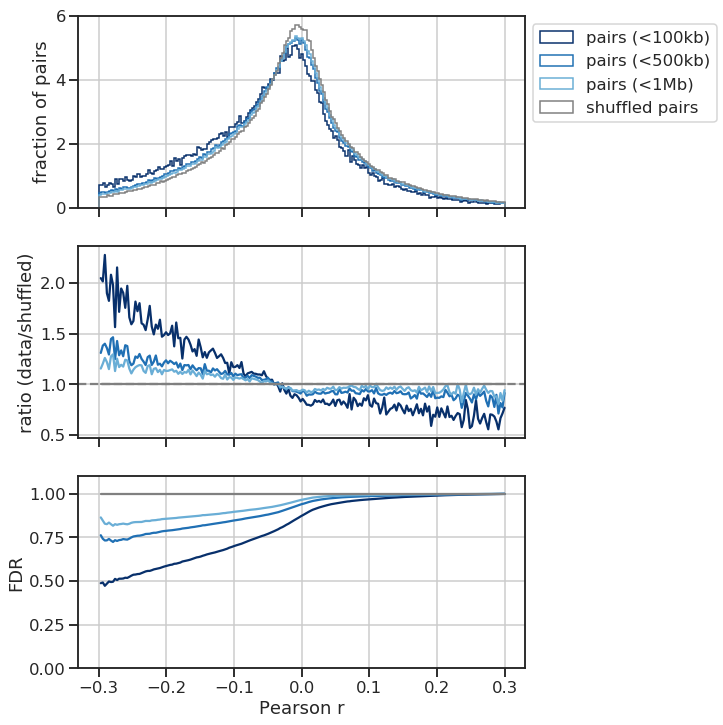

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in true_divide
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


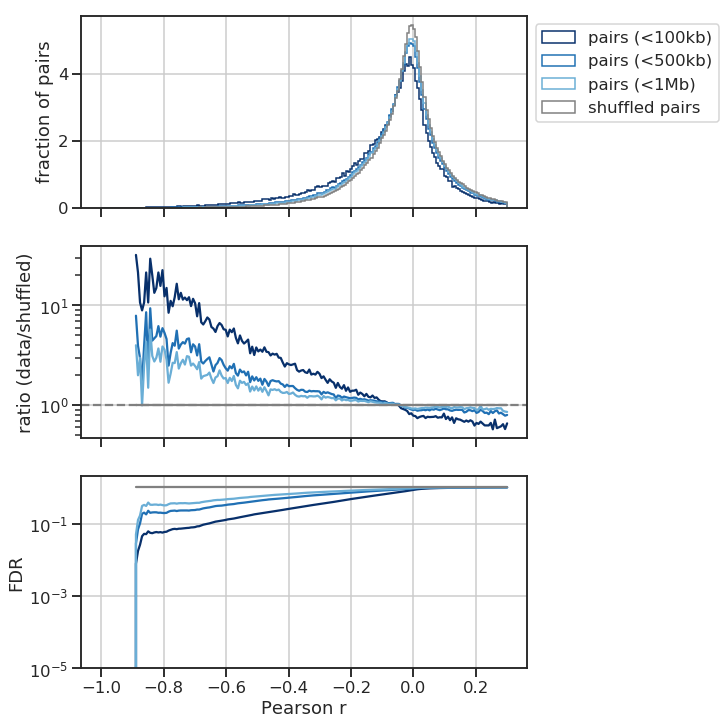

In [14]:
# figure 1
num_bins = 200
bins = np.linspace(-0.3, 0.3, num_bins)

tracks_hist_ratios = {}
track_cdfs = {}
fdr_cdfs = {}

hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
cdf_shuff = np.cumsum(hist_shuff)
for label, track in tracks.items():
    hist, _ = np.histogram(track, bins=bins, normed=True)
    cdf = np.cumsum(hist)
    fdr = cdf_shuff/cdf
    tracks_hist_ratios[label] = hist/hist_shuff
    track_cdfs[label] = cdf 
    fdr_cdfs[label] = fdr

fig, axs = plt.subplots(3, 1, figsize=(4*2,4*3), sharex=True)

ax = axs[0]
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('fraction of pairs')

ax = axs[1]
for label, track in tracks_hist_ratios.items():
    ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
ax.axhline(1, linestyle='--', color='gray')
ax.set_ylabel('ratio (data/shuffled)')

ax = axs[2]
for label, track in fdr_cdfs.items():
    ax.plot(bins[1:], track, color=track_colors[label])
ax.set_ylim([0, 1.1])
ax.set_ylabel('FDR')
ax.set_xlabel('Pearson r')

snmcseq_utils.savefig(fig, output_figure1)
plt.show()

# figure 2
num_bins = 200
bins = np.linspace(-1, 0.3, num_bins)

tracks_hist_ratios = {}
track_cdfs = {}
fdr_cdfs = {}

hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
cdf_shuff = np.cumsum(hist_shuff)
for label, track in tracks.items():
    hist, _ = np.histogram(track, bins=bins, normed=True)
    cdf = np.cumsum(hist)
    fdr = cdf_shuff/cdf
    tracks_hist_ratios[label] = hist/hist_shuff
    track_cdfs[label] = cdf 
    fdr_cdfs[label] = fdr
fig, axs = plt.subplots(3, 1, figsize=(4*2,4*3), sharex=True)

ax = axs[0]
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('fraction of pairs')

ax = axs[1]
for label, track in tracks_hist_ratios.items():
    ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
ax.set_yscale('log')
ax.axhline(1, linestyle='--', color='gray')
ax.set_ylabel('ratio (data/shuffled)')

ax = axs[2]
for label, track in fdr_cdfs.items():
    ax.plot(bins[1:], track, color=track_colors[label])
ax.set_ylim([1e-5, 2])
ax.set_yscale('log')
ax.set_ylabel('FDR')
ax.set_xlabel('Pearson r')

snmcseq_utils.savefig(fig, output_figure2)
plt.show()